# Image Recognition: Classifying landcover (NWPU-RESISC45) using transfer learning, and from scratch


#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

## Introduction

This tutorial shows how to do whole image classification, or image `recognition`, starting from JPEG image files, first leveraging pre-trained weights (transfer learning), then training the same model from scratch, without transfer learning.

Finally, we see what classification accuracy we might achieve using a deep learning model with pre-trained weights without any additional training. This is a form of semi-supervised training, leverage weights from another dataset and labels from this

We demonstrate the workflow on the [NWPU-RESISC45](http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html) classification dataset, using image augmentation

NWPU-RESISC45 dataset is a publicly available benchmark for REmote Sensing Image Scene Classification (RESISC), created by Northwestern Polytechnical University (NWPU). This dataset contains 31,500 images, covering 45 scene classes with 700 images in each class. These 45 scene classes include airplane, airport, baseball diamond, basketball court, beach, bridge, chaparral, church, circular farmland, cloud, commercial area, dense residential, desert, forest, freeway, golf course, ground track field, harbor, industrial area, intersection, island, lake, meadow, medium residential, mobile home park, mountain, overpass, palace, parking lot, railway, railway station, rectangular farmland, river, roundabout, runway, seaice, ship, snowberg, sparse residential, stadium, storage tank, tennis court, terrace, thermal power station, and wetland.

We see that the training on top of pretrained weights approach yielded a mean classification accuracy across 45 classes is ~78 percent. That increased to ~90 percent when trained from scratch. Finally, a semi-supervised model has an accuracy of ~63%. Clearly, the degree of training matters: the most trained was most accurate and the least trained the least accurate



## Setup

In [1]:
import requests, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np
from glob import glob

## Load the data: NWPU-RESISC45


In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

First, let's download the 200M zip archive of the raw training data:

In [0]:
file_id = '1ZpvsgRVfOrr6gTuSdeJP828YvoC7PqxS'
destination = 'train_images.zip'
download_file_from_google_drive(file_id, destination)

First, let's download the 200M zip archive of the raw testing data:

In [0]:
file_id = '1uaj2iVuSJ0FCSUkoC9jG_haeJbQzxnfo'
destination = 'test_images.zip'
download_file_from_google_drive(file_id, destination)

In this example I have pre-sorted the imagery into train and test splits, by randomly selecting from among the images in each class

Unzip both zipped files (piping output to `tmp.txt` so we don't clutter our screens with lots of output) 

In [0]:
!unzip train_images.zip > tmp.txt
!unzip test_images.zip > tmp.txt

What categories do we have?

In [8]:
!ls test

airplane	   golf_course	       railway_station
airport		   ground_track_field  rectangular_farmland
baseball_diamond   harbor	       river
basketball_court   industrial_area     roundabout
beach		   intersection        runway
bridge		   island	       sea_ice
chaparral	   lake		       ship
church		   meadow	       snowberg
circular_farmland  medium_residential  sparse_residential
cloud		   mobile_home_park    stadium
commercial_area    mountain	       storage_tank
dense_residential  overpass	       tennis_court
desert		   palace	       terrace
forest		   parking_lot	       thermal_power_station
freeway		   railway	       wetland


Get a list of subdirectories as classes

In [0]:
D = []
for k in os.walk('train'):
  D.append(k)

In [10]:
classes = sorted(D[0][1])
print(classes)

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


## Augmenting the data

In [0]:
batch_size = 16


Our image are already in a standard size (256 x 256). However, their RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a `rescale` in our augmentation function

We'll augment the data with random zooms up to 30%, shear up to 10%, rotations up to 30 degrees, and horizontal and vertical flipping

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        zoom_range=0.3,
        shear_range=0.1,
        vertical_flip = True,
        rotation_range=30,
        horizontal_flip=True,
        rescale=1./255,
        fill_mode='reflect')

img_generator = datagen.flow_from_directory(
        "train",
        target_size=(256, 256),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', seed=2020)

Found 15227 images belonging to 45 classes.


Do the same for the validation (test) set

In [13]:
val_generator = datagen.flow_from_directory(
        "test",
        target_size=(256, 256),
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', classes=classes, seed=2020)

Found 15118 images belonging to 45 classes.


## Visualize the data

Here are the first 8 images in the training dataset. 

In [0]:
x, y = next(img_generator)

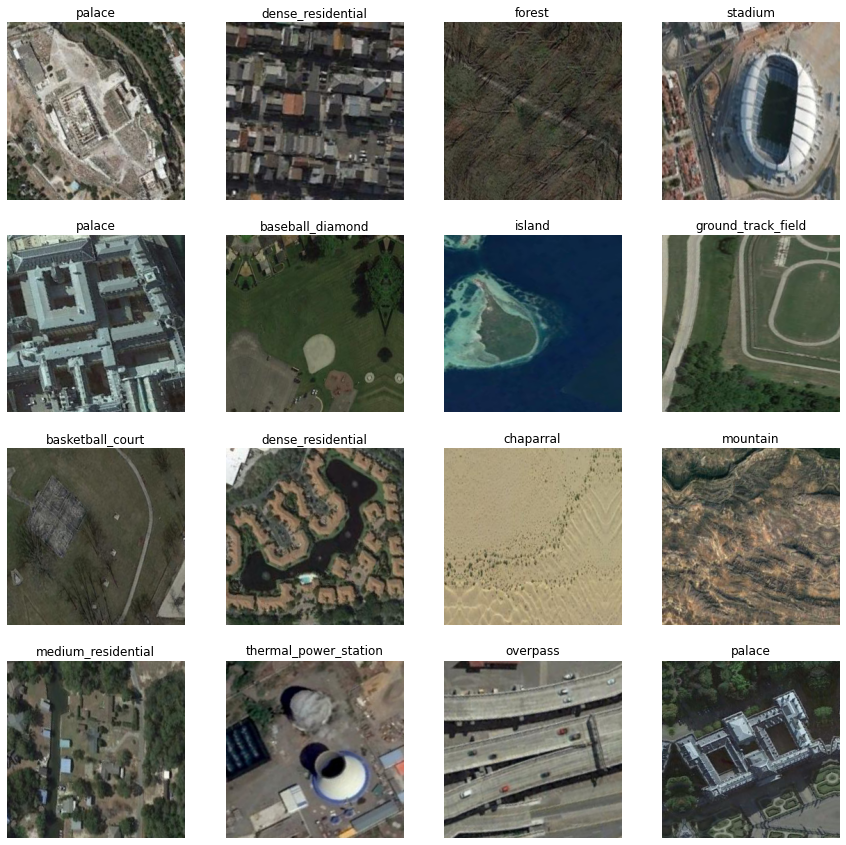

In [15]:

plt.figure(figsize=(15, 15))
counter = 1
for im, l in zip(x,y):
    ax = plt.subplot(4, 4,counter)
    plt.imshow(im)

    plt.title(classes[np.argmax(l)])
    plt.axis('off')
    counter +=1

plt.show()


## Image classification using transfer learning

### Build a model


We'll use one of the 'stock' models provided by `keras.applications` called MobileNetV2

In [0]:
from tensorflow.keras.applications import MobileNetV2

Load the MobileNetV2 model trained on imagenet, but exclude the classification layers, because we want to add our own classification layers so we can retrain the model on our own categories

In [0]:
def transfer_learning_mobilenet_model(num_classes, input_shape): 
    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                        input_shape=input_shape)

    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model

In [0]:
input_shape = (224, 224) 

9412608/9406464 [==============================] - 0s 0us/step


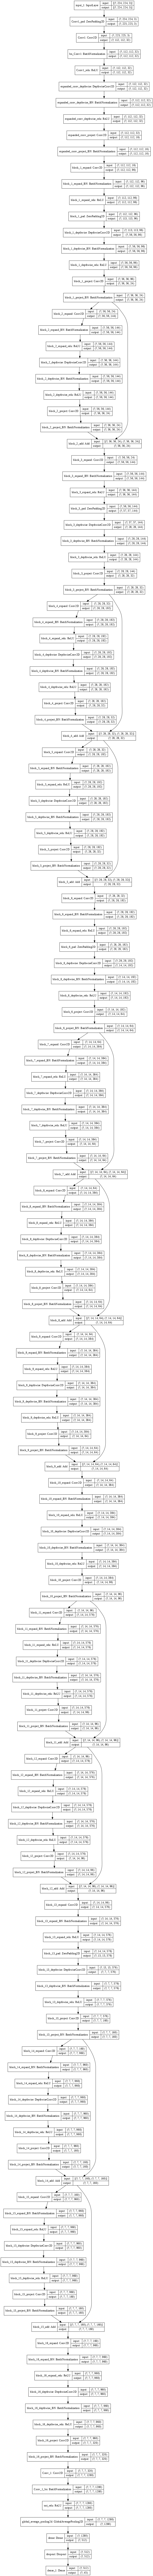

In [19]:
model1 = transfer_learning_mobilenet_model(len(classes), input_shape+(3,) )
keras.utils.plot_model(model1, show_shapes=True, dpi=64)

### Train the model

In [20]:
img_generator = datagen.flow_from_directory(
        "train",
        target_size=input_shape,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', seed=2020)

val_generator = datagen.flow_from_directory(
        "test",
        target_size=input_shape,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', seed=2020)

Found 15227 images belonging to 45 classes.
Found 15118 images belonging to 45 classes.


In [0]:
filepath = 'nwpu45_mn2_best_weights.h5'

We are using early stopping and adaptive learning rates

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [0]:
min_lr = 1e-4
patience = 5
factor = 0.8
cooldown = 3

In [0]:
earlystop = EarlyStopping(monitor="val_loss", 
                              mode="min", patience=patience) 

# reduction of learning rate if and when validation scores plateau upon successive epochs
reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                verbose=1, mode='auto', 
                                cooldown=cooldown, min_lr=min_lr)

# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

Compile the model

In [0]:
model1.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [26]:
history = model1.fit(img_generator, epochs=10, callbacks=callbacks, validation_data=val_generator)

Epoch 1/10
952/952 [==============================] - 342s 359ms/step - loss: 1.6461 - accuracy: 0.5411 - val_loss: 0.9348 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 2/10
952/952 [==============================] - 337s 354ms/step - loss: 1.1455 - accuracy: 0.6576 - val_loss: 0.8366 - val_accuracy: 0.7433 - lr: 0.0010
Epoch 3/10
952/952 [==============================] - 336s 353ms/step - loss: 1.0515 - accuracy: 0.6905 - val_loss: 0.7917 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 4/10
952/952 [==============================] - 344s 362ms/step - loss: 1.0014 - accuracy: 0.7021 - val_loss: 0.7781 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 5/10
952/952 [==============================] - 341s 358ms/step - loss: 0.9631 - accuracy: 0.7111 - val_loss: 0.7632 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 6/10
952/952 [==============================] - 338s 355ms/step - loss: 0.9296 - accuracy: 0.7226 - val_loss: 0.7334 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 7/10
952/952 [==========================

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [0]:
n = len(history.history['accuracy'])

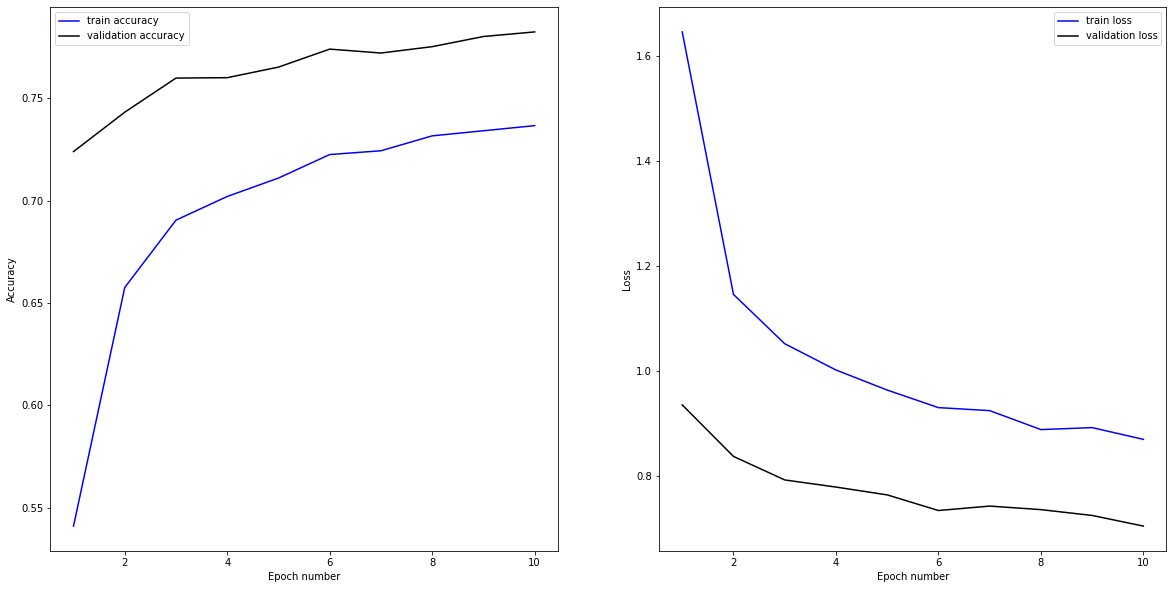

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(np.arange(1,n+1), history.history['accuracy'], 'b', label='train accuracy')
plt.plot(np.arange(1,n+1), history.history['val_accuracy'], 'k', label='validation accuracy')
plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Accuracy', fontsize=10)
plt.legend(fontsize=10)

plt.subplot(122)
plt.plot(np.arange(1,n+1), history.history['loss'], 'b', label='train loss')
plt.plot(np.arange(1,n+1), history.history['val_loss'], 'k', label='validation loss')
plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

### Run inference on new data

Let's test the model on a test sample image

(note that Dropout are inactive at inference time, so that layer won't affect our model results)

In [0]:
x, y = next(val_generator)

This image is airplane.


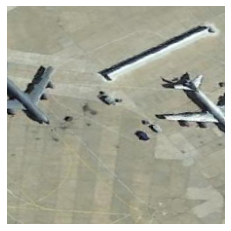

In [125]:
img_array = tf.expand_dims(x[0], 0)  # Create batch axis

plt.imshow(x[0])
plt.axis('off')

scores = model1.predict(img_array, batch_size=1)
counter = np.argmax(scores[0])
print('This image is %s.' % (sorted(classes)[counter]))

We can use the `model.evaluate()` function to evaluate the average accuracy for the entire test set

In [31]:
scores = model1.evaluate(val_generator)

945/945 [==============================] - 168s 178ms/step - loss: 0.7132 - accuracy: 0.7803


### Plotting the confusion matrix

We need a new validation generator with shuffle set to `False` in order to evaluate the model

In [32]:
val_generator = datagen.flow_from_directory(
        "test",
        target_size=input_shape,
        batch_size=batch_size,
        shuffle=False,  # no shuffle
        class_mode='categorical')

Found 15118 images belonging to 45 classes.


In [0]:
preds = model1.predict(val_generator)
pred = np.argmax(preds, axis=1)

In [34]:
len(pred)

15118

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# plot the confusion matrix
cm = confusion_matrix(val_generator.classes, pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

To make the plot cleaner, we'll set all the scores less than a certain threshold to be zero

In [0]:
thres = 0.1
cm[cm<thres] = 0

Plot the matrix as a heatmap, make the labels small and rotate them 45 degrees

([<matplotlib.axis.YTick at 0x7f9b96f19048>,
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'airport'),
  Text(0, 2.5, 'baseball_diamond'),
  Text(0, 3.5, 'basketball_court'),
  Text(0, 4.5, 'beach'),
  Text(0, 5.5, 'bridge'),
  Text(0, 6.5, 'chaparral'),
  Text(0, 7.5, 'church'),
  Text(0, 8.5, 'circular_farmland'),
  Text(0, 9.5, 'cloud'),
  Text(0, 10.5, 'commercial_area'),
  Text(0, 11.5, 'dense_residential'),
  Text(0, 12.5, 'desert'),
  Text(0, 13.5, 'forest'),
  Text(0, 14.5, 'freeway'),
  Text(0, 15.5, 'golf_course'),
  Text(0, 16.5, 'ground_track_field'),
  Text(0, 17.5, 'harbor'),
  Text(0, 18.5, 'industrial_area'),
  Text(0, 19.5, 'intersection'),
  Text(0, 20.5, 'island'),
  Text(0, 21.5, 'lake'),
  Text(0, 22.5, 'meadow'),
  Text(0, 23.5, 'medium_residential'),
  Text(0, 24.5, 'mobile_home_park'),
  Text(0, 25.5, 'mountain'),
  Text(0, 26.5, 'overpass'),
  Text(0, 27.5, 'palace'),
  Text(0, 28.5, 'parking_lot'),
  Text(0, 29.5, 'railway'),
  Text(0, 30.5, 'railway_station'),
 

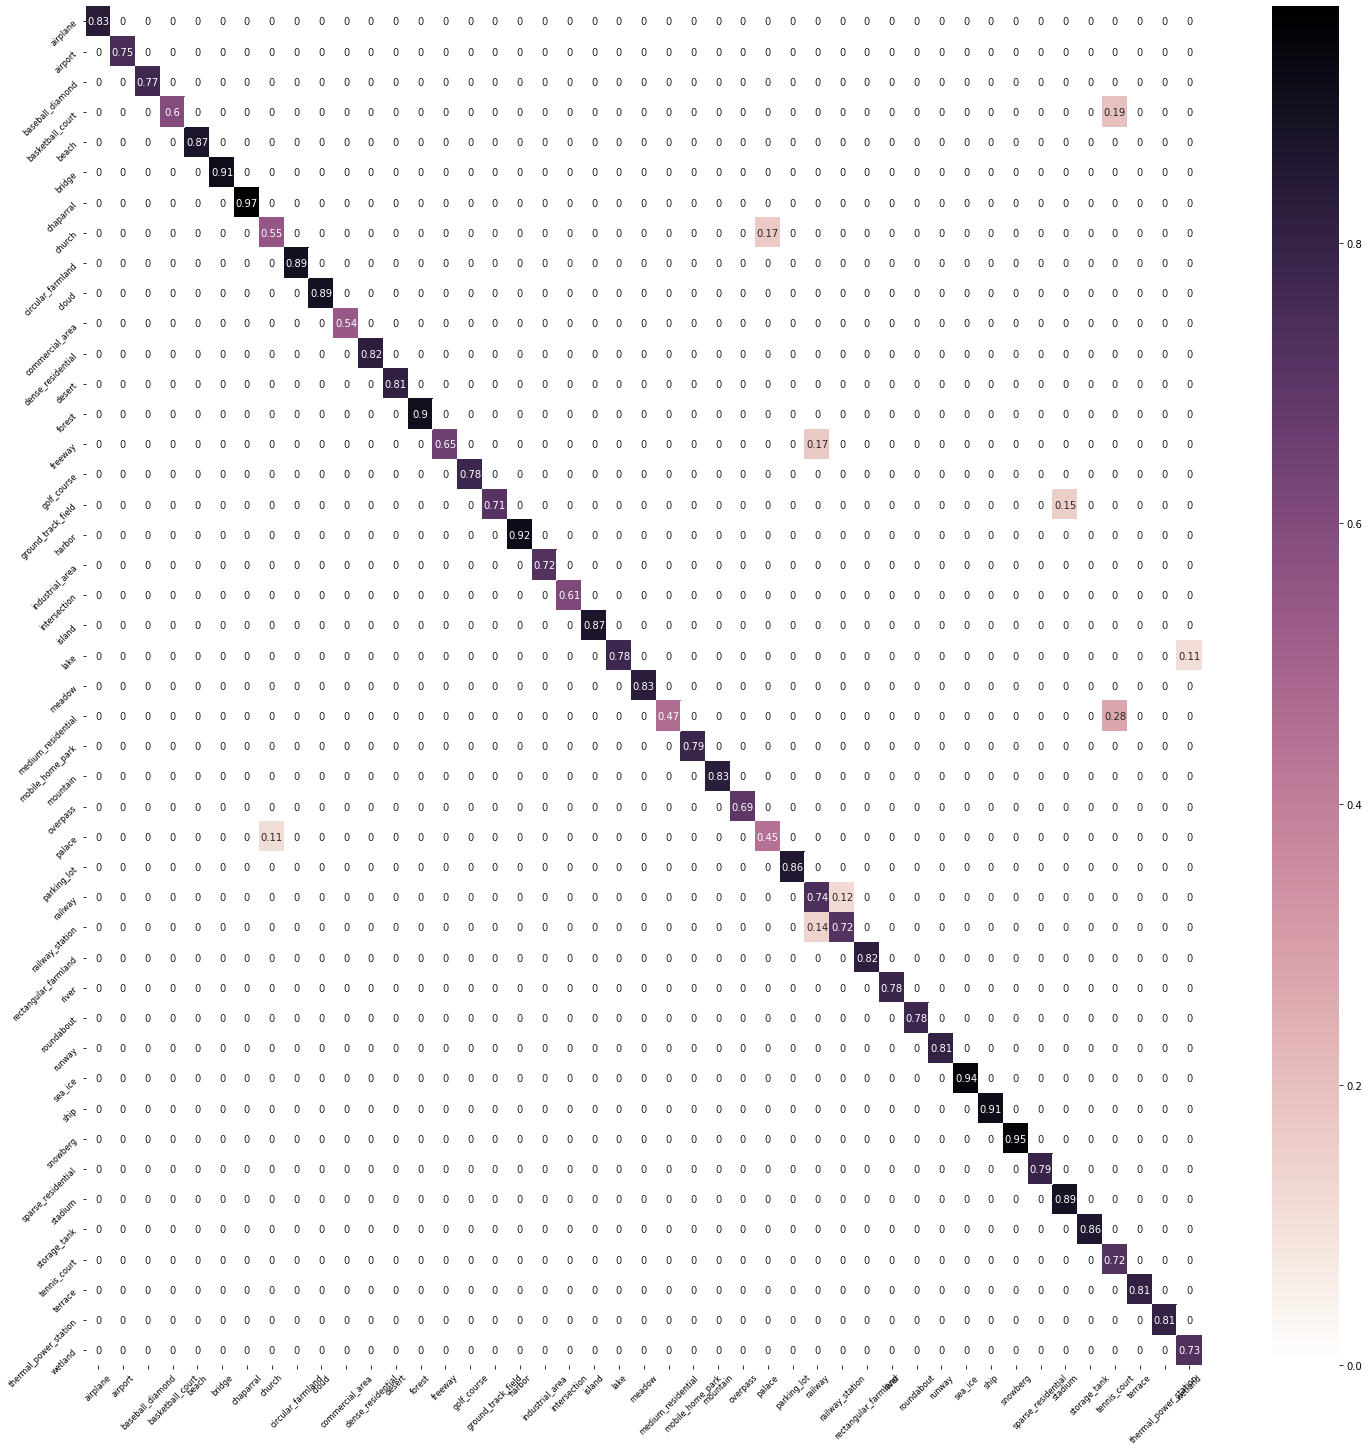

In [38]:
plt.figure(figsize=(25,25))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

In [43]:
print('Mean classification accuracy across %i classes is %.0f percent' % (len(classes), 100*np.mean(np.diag(cm))))

Mean classification accuracy across 45 classes is 78 percent


## Building an image classifier from scratch

### Build a model


In [0]:
def mobilenet_model(num_classes, input_shape): 
    EXTRACTOR = MobileNetV2(include_top=False,
                        input_shape=input_shape)

    EXTRACTOR.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model    

In [0]:
model2 = mobilenet_model(len(classes), input_shape+(3,) )

### Train the model

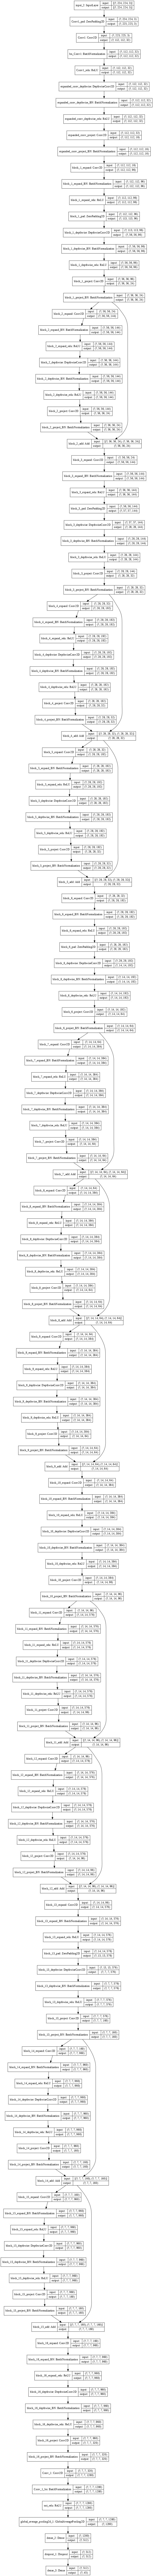

In [46]:
keras.utils.plot_model(model2, show_shapes=True, dpi=64)

In [0]:
min_lr = 1e-4
patience = 5
factor = 0.8
cooldown = 3

max_epochs = 50

In [0]:
model2.compile(optimizer=keras.optimizers.Adam(min_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We'll use a couple of keras' callback functions to set learning rates and invoke 'early stopping' to model training 

The adaptive learning rate function, `ReduceLROnPlateau`, monitors validation loss during model training and reduces learning rates accordingly

The `EarlyStopping` function will monitor validation loss and will terminate model training if the loss doesn't improve (i.e. get smaller) over `patience` epochs

Finally, we'll use the `ModelCheckpoint` function to save the best model weights only

In [0]:
earlystop = EarlyStopping(monitor="val_loss", 
                              mode="min", patience=patience) 

# reduction of learning rate if and when validation scores plateau upon successive epochs
reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                verbose=1, mode='auto', 
                                cooldown=cooldown, min_lr=min_lr)

# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

In [50]:
val_generator = datagen.flow_from_directory(
        "test",
        target_size=input_shape,
        batch_size=batch_size,
        shuffle=True,  # shuffle for training
        class_mode='categorical')

Found 15118 images belonging to 45 classes.


train the model

In [51]:
model2.fit(img_generator, epochs=max_epochs, callbacks=callbacks, validation_data=val_generator)

Epoch 1/50
952/952 [==============================] - 352s 370ms/step - loss: 1.6573 - accuracy: 0.5520 - val_loss: 1.5034 - val_accuracy: 0.5715 - lr: 1.0000e-04
Epoch 2/50
952/952 [==============================] - 345s 363ms/step - loss: 0.7358 - accuracy: 0.7851 - val_loss: 0.9190 - val_accuracy: 0.7385 - lr: 1.0000e-04
Epoch 3/50
952/952 [==============================] - 344s 361ms/step - loss: 0.5745 - accuracy: 0.8283 - val_loss: 0.5768 - val_accuracy: 0.8325 - lr: 1.0000e-04
Epoch 4/50
952/952 [==============================] - 343s 361ms/step - loss: 0.4844 - accuracy: 0.8537 - val_loss: 0.4859 - val_accuracy: 0.8589 - lr: 1.0000e-04
Epoch 5/50
952/952 [==============================] - 344s 362ms/step - loss: 0.4260 - accuracy: 0.8727 - val_loss: 0.4751 - val_accuracy: 0.8664 - lr: 1.0000e-04
Epoch 6/50
952/952 [==============================] - 344s 361ms/step - loss: 0.3982 - accuracy: 0.8815 - val_loss: 0.3939 - val_accuracy: 0.8879 - lr: 1.0000e-04
Epoch 7/50
952/952 [==

### Run inference on new data

Dropout are inactive at inference time, so that layer won't affect our model results

In [0]:
x, y = next(val_generator)

This image is airplane.


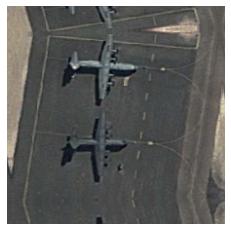

In [123]:
img_array = tf.expand_dims(x[0], 0)  # Create batch axis

plt.imshow(x[0])
plt.axis('off')

scores = model2.predict(img_array, batch_size=1)
counter = np.argmax(scores[0])
print('This image is %s.' % (sorted(classes)[counter]))

Get the model scores on the test set

In [53]:
scores = model2.evaluate(val_generator)

945/945 [==============================] - 161s 170ms/step - loss: 0.3535 - accuracy: 0.9072


### Plotting the confusion matrix

We need a new validation generator with shuffle set to `False` in order to evaluate the model

In [54]:
val_generator = datagen.flow_from_directory(
        "test",
        target_size=input_shape,
        batch_size=batch_size,
        shuffle=False,  # no shuffle
        class_mode='categorical')

Found 15118 images belonging to 45 classes.


Get predictions for each test image

In [0]:
preds = model2.predict(val_generator)
pred = np.argmax(preds, axis=1)

In [56]:
len(pred)

15118

Get the confusion matrix and normalize so the rows sum to 1

In [0]:
cm = confusion_matrix(val_generator.classes, pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

To make the plot cleaner, we'll set all the scores less than a certain threshold to be zero

In [0]:
thres = 0.1
cm[cm<thres] = 0

Plot the matrix as a heatmap, make the labels small and rotate them 45 degrees

([<matplotlib.axis.YTick at 0x7f9b9126f208>,
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'airport'),
  Text(0, 2.5, 'baseball_diamond'),
  Text(0, 3.5, 'basketball_court'),
  Text(0, 4.5, 'beach'),
  Text(0, 5.5, 'bridge'),
  Text(0, 6.5, 'chaparral'),
  Text(0, 7.5, 'church'),
  Text(0, 8.5, 'circular_farmland'),
  Text(0, 9.5, 'cloud'),
  Text(0, 10.5, 'commercial_area'),
  Text(0, 11.5, 'dense_residential'),
  Text(0, 12.5, 'desert'),
  Text(0, 13.5, 'forest'),
  Text(0, 14.5, 'freeway'),
  Text(0, 15.5, 'golf_course'),
  Text(0, 16.5, 'ground_track_field'),
  Text(0, 17.5, 'harbor'),
  Text(0, 18.5, 'industrial_area'),
  Text(0, 19.5, 'intersection'),
  Text(0, 20.5, 'island'),
  Text(0, 21.5, 'lake'),
  Text(0, 22.5, 'meadow'),
  Text(0, 23.5, 'medium_residential'),
  Text(0, 24.5, 'mobile_home_park'),
  Text(0, 25.5, 'mountain'),
  Text(0, 26.5, 'overpass'),
  Text(0, 27.5, 'palace'),
  Text(0, 28.5, 'parking_lot'),
  Text(0, 29.5, 'railway'),
  Text(0, 30.5, 'railway_station'),
 

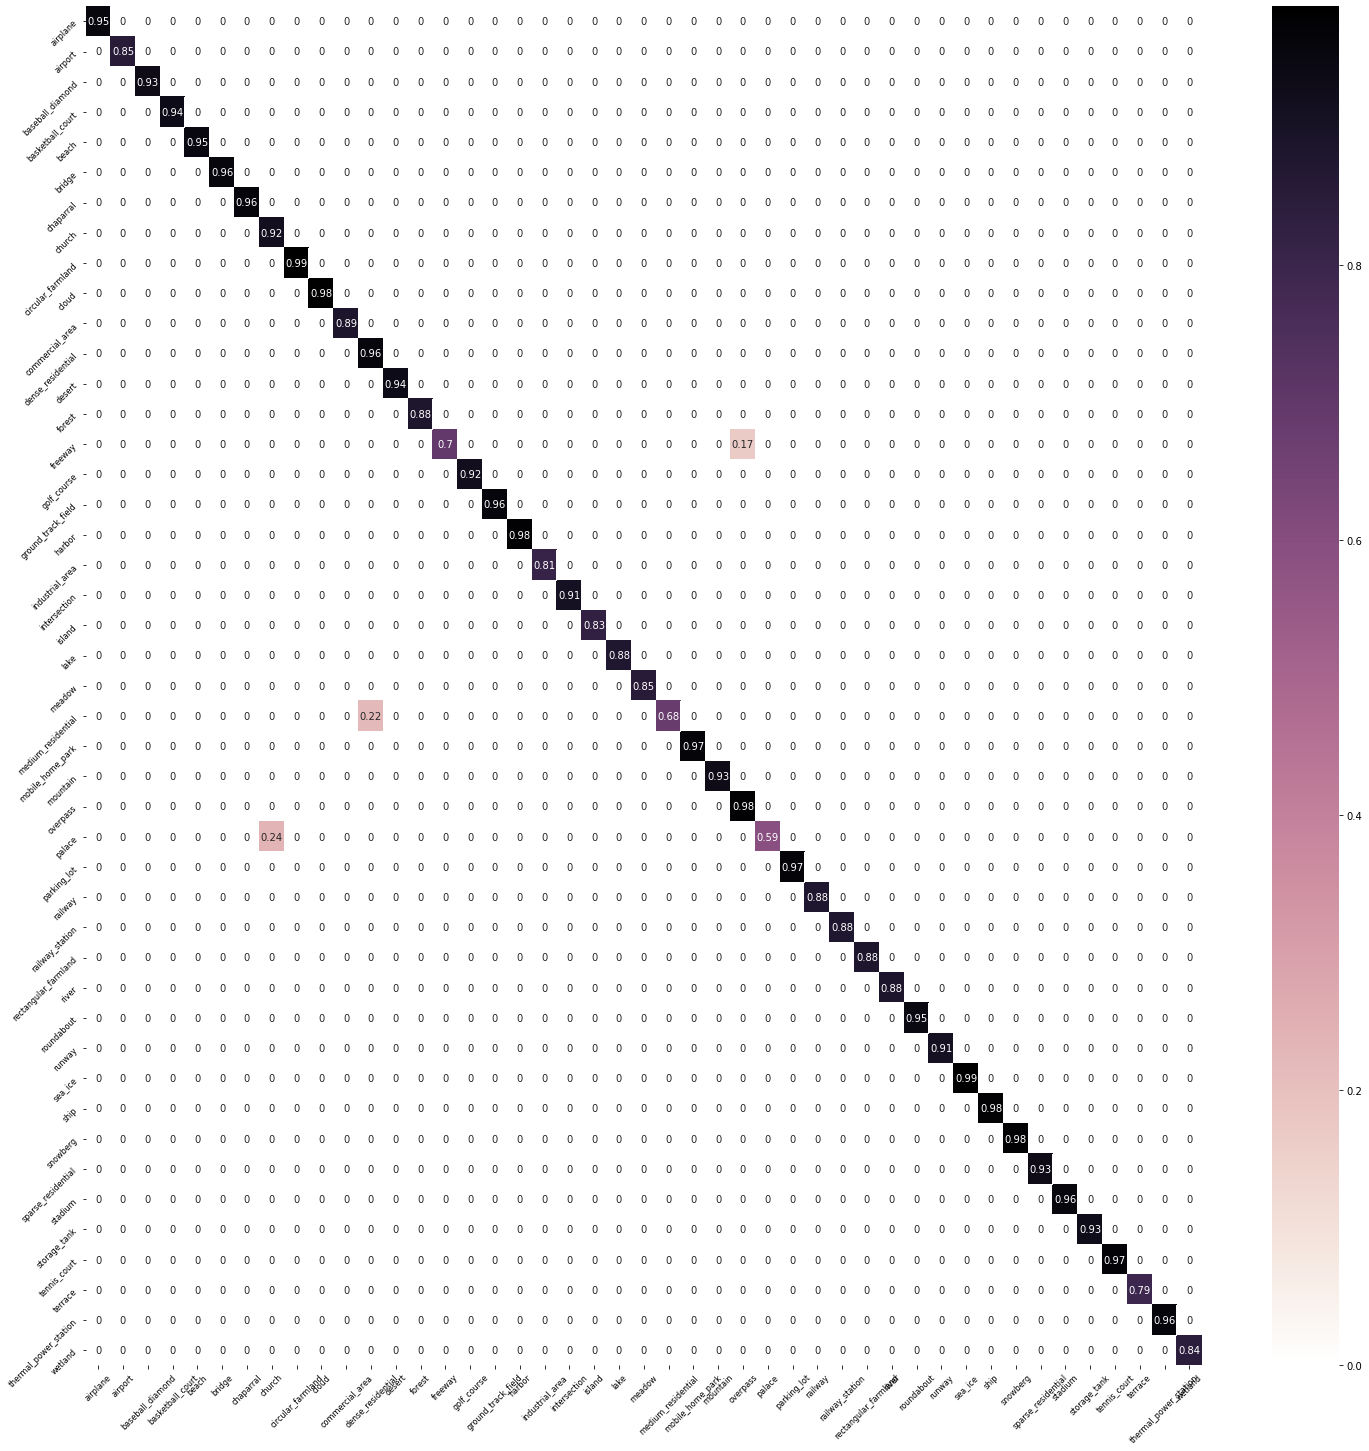

In [59]:
plt.figure(figsize=(25,25))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

The mean true positive classification rate is the mean of the matrix diagonal elements

In [60]:
print("Average accuracy across 45 classes: %.3f" % (np.mean(np.diag(cm))))

Average accuracy across 45 classes: 0.907


### Semi-supervised image classification without training a deep learning model

We see what classification accuracy we might achieve using a deep learning model with pre-trained weights without any additional training. This is a form of semi-supervised training, leverage weights from another dataset and labels from this

We use a deep learning model to extract features, combined with a classical ML model for image classification

The workflow below shows how to take a deep learning model that is trained on images (imagenet) and use it as an image feature extractor within a classical machine learning model.

We'll use logistic regression for the task. This is similar to the approach taken by [Buscombe and Carini, 2019](https://www.mdpi.com/2072-4292/11/7/859) to classify wave breaking

First we make a new image generator with one large batch of all images

In [0]:
input_shape = (224, 224)

In [62]:
img_generator = datagen.flow_from_directory(
        "train",
        target_size=input_shape,
        batch_size=1000,
        shuffle=True,
        class_mode='categorical', seed=2020)

Found 15227 images belonging to 45 classes.


Grabn those images and labels and store them in memory

In [0]:
ims, labs = next(img_generator)

Get a feature extractor model without the classifying layers (`include_top = False`) and pre-loaded with weights trained on imagenet

This will be our generic feature extractor

In [0]:
EXTRACTOR = MobileNetV2(include_top=False, input_shape=input_shape + (3,) , weights = 'imagenet')
EXTRACTOR.compile(optimizer=keras.optimizers.Adam(min_lr), loss='categorical_crossentropy', metrics=['accuracy'])

Cycle through each and use the model to extract features from each sample image, as well as the known label

This will take a while because there are a lot of images

In [0]:
# variables to hold features and labels
features = []
labels   = []

for k in range(len(ims)):
    im = tf.expand_dims(ims[k], 0)  # Create batch axis
    #f = model2.predict(im).flatten()
    f = EXTRACTOR.predict(im).flatten()
    features.append(f)
    labels.append(np.argmax(labs[k]))

In [66]:
len(labels)

1000

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
	# encode the labels using LabelEncoder
	le = LabelEncoder()
	le_labels = le.fit_transform(labels)

In [0]:
trainData = np.array(features)
trainLabels = np.array(le_labels)

We have 1000 image feature vectors, each 62720 elements long. We will be using logistic regression to fit those data to the corresponding labels

In [70]:
trainData.shape

(1000, 62720)

Get a new image generator for the test set

In [71]:
img_generator = datagen.flow_from_directory(
        "test",
        target_size=input_shape,
        batch_size=1000,
        shuffle=True,
        class_mode='categorical', seed=2020)

Found 15118 images belonging to 45 classes.


Get those images and labels

In [0]:
ims, labs = next(img_generator)

In [0]:
# variables to hold features and labels
features = []
labels   = []

for k in range(len(ims)):
    im = tf.expand_dims(ims[k], 0)  # Create batch axis
    f = EXTRACTOR.predict(im).flatten()
    features.append(f)
    labels.append(np.argmax(labs[k]))

In [0]:
	# encode the labels using LabelEncoder
	le = LabelEncoder()
	le_labels = le.fit_transform(labels)

In [0]:
testData = np.array(features)
testLabels = np.array(le_labels)

In [77]:
testData.shape

(1000, 62720)

Fit the `LogisticRegression` function in scikit-learn

In [87]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=0.5, dual=False, random_state=2020, max_iter=1000)
classifier.fit(trainData, trainLabels) 

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Compute the rank-1 and rank-5 accuracies

In [0]:
rank_1 = 0
rank_5 = 0

# loop over test data
for (label, features) in zip(testLabels, testData):
    # predict the probability of each class label and
    # take the top-5 class labels
    predictions = classifier.predict_proba(np.atleast_2d(features))[0]
    predictions = np.argsort(predictions)[::-1][:5]

    # rank-1 prediction increment
    if label == predictions[0]:
      rank_1 += 1

    # rank-5 prediction increment
    if label in predictions:
      rank_5 += 1

    # convert accuracies to percentages
    rank_1 = (rank_1 / float(len(testLabels))) * 100
    rank_5 = (rank_5 / float(len(testLabels))) * 100

In [96]:
print("Rank-1 score: %.2f" % (rank_1))
print("Rank-5 score: %.2f" % (rank_5))

Rank-1 score: 0.10
Rank-5 score: 0.11


In [0]:
# evaluate the model of test data
preds = classifier.predict(testData)

In [0]:
cm = confusion_matrix(testLabels, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

To make the plot cleaner, we'll set all the scores less than a certain threshold to be zero

In [0]:
thres = 0.1
cm[cm<thres] = 0

Plot the matrix as a heatmap, make the labels small and rotate them 45 degrees

([<matplotlib.axis.YTick at 0x7f9b07d72748>,
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'airport'),
  Text(0, 2.5, 'baseball_diamond'),
  Text(0, 3.5, 'basketball_court'),
  Text(0, 4.5, 'beach'),
  Text(0, 5.5, 'bridge'),
  Text(0, 6.5, 'chaparral'),
  Text(0, 7.5, 'church'),
  Text(0, 8.5, 'circular_farmland'),
  Text(0, 9.5, 'cloud'),
  Text(0, 10.5, 'commercial_area'),
  Text(0, 11.5, 'dense_residential'),
  Text(0, 12.5, 'desert'),
  Text(0, 13.5, 'forest'),
  Text(0, 14.5, 'freeway'),
  Text(0, 15.5, 'golf_course'),
  Text(0, 16.5, 'ground_track_field'),
  Text(0, 17.5, 'harbor'),
  Text(0, 18.5, 'industrial_area'),
  Text(0, 19.5, 'intersection'),
  Text(0, 20.5, 'island'),
  Text(0, 21.5, 'lake'),
  Text(0, 22.5, 'meadow'),
  Text(0, 23.5, 'medium_residential'),
  Text(0, 24.5, 'mobile_home_park'),
  Text(0, 25.5, 'mountain'),
  Text(0, 26.5, 'overpass'),
  Text(0, 27.5, 'palace'),
  Text(0, 28.5, 'parking_lot'),
  Text(0, 29.5, 'railway'),
  Text(0, 30.5, 'railway_station'),
 

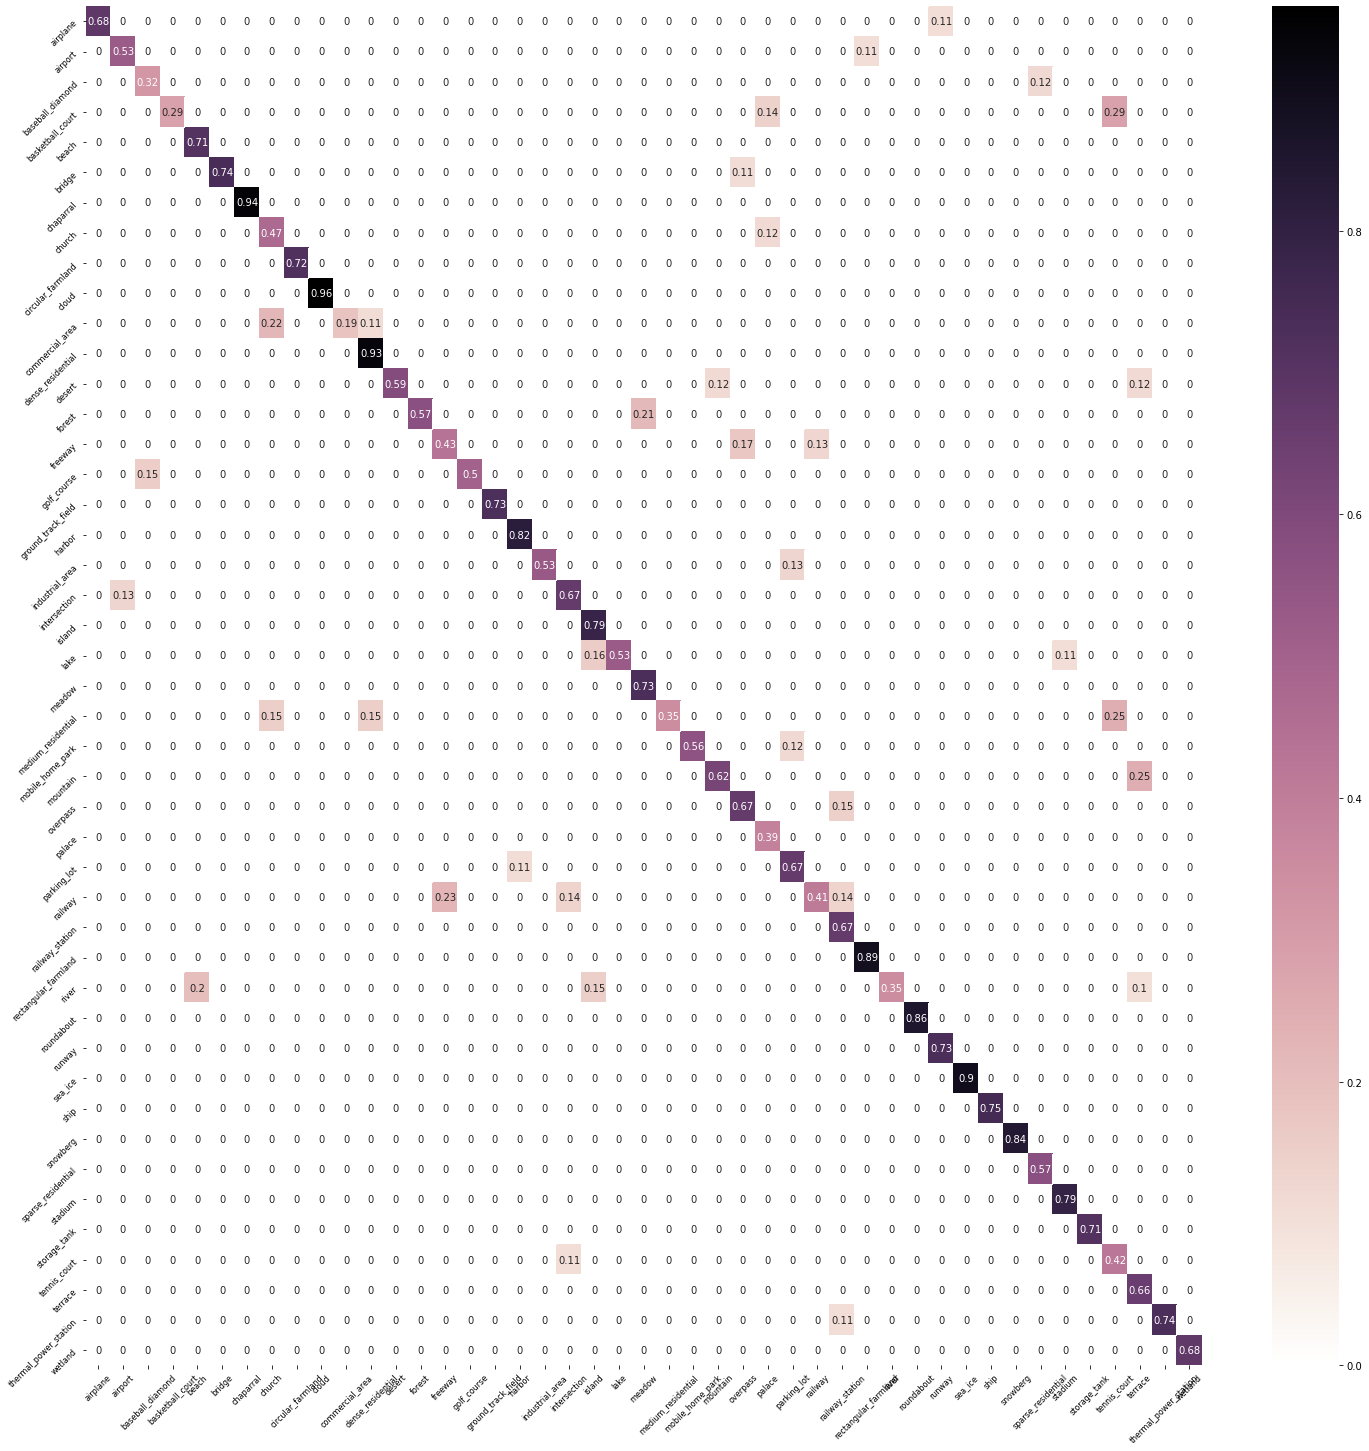

In [100]:
plt.figure(figsize=(25,25))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=8)
plt.yticks(tick_marks, classes,rotation=45, fontsize=8)	

In [101]:
print("Average accuracy across 45 classes: %.3f" % (np.mean(np.diag(cm))))

Average accuracy across 45 classes: 0.635
